# TFM : Aplicación de *Machine Learning* para la Gestión de Inventarios
> Erendira Teresa Navarro García

**Lectura de datos, análisis exploratorio y proceso de limpieza y transformación**

In [ ]:
# Python 3 environment Google Colab
import pandas as pd
import os
import csv
import datetime as datetime
import json 
import datetime as dttm #time/date manipulations
import sklearn
import numpy as np
import math
import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pylab as plab
from sklearn.model_selection import train_test_split
from datetime import datetime
from dateutil.parser import parse
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Lectura de datos

In [ ]:
dateparse = lambda x: datetime.strptime(x, '%Y%m%d')
df_sales = pd.read_excel('/content/drive/MyDrive/Files_TFM/Datos11.xlsx', sheet_name='Venta',
                         parse_dates=['fecha'], date_parser=dateparse, dtype={'sku': str})
df_calendar = pd.read_excel('/content/drive/MyDrive/Files_TFM/Datos11.xlsx', sheet_name='Calendarios',
                            parse_dates=['fecha'], date_parser=dateparse, dtype={'sku': str})
df_promos = pd.read_excel('/content/drive/MyDrive/Files_TFM/Datos11.xlsx', sheet_name='Promos',
                          parse_dates=['fechaIni', 'fechaFin'], date_parser=dateparse, dtype={'sku': str})
df_stock = pd.read_excel('/content/drive/MyDrive/Files_TFM/Datos11.xlsx', sheet_name='Stock',
                         parse_dates=['fecha'], date_parser=dateparse, dtype={'sku': str})

In [ ]:
#Print dimensions & first few rows of dataframe
df_dims = []
i = 0
names_df = ["Venta","Calendarios","Promos", "Stock"]
for df in [df_sales,df_calendar, df_promos, df_stock]:
  df_dims.append([names_df[i], df.shape[0],df.shape[1]])
  i += 1
df_dimensiones = pd.DataFrame(data = df_dims, columns = ['df_name','rows','columns'])

In [ ]:
df_dimensiones

,df_name,rows,columns
0,Venta,51097,3
1,Calendarios,126050,4
2,Promos,2006,3
3,Stock,32950,3


In [ ]:
print(tabulate(df_dimensiones.set_index("df_name"), headers=df_dimensiones.columns, tablefmt='latex'))

\begin{tabular}{lrr}
\hline
 df\_name     &   rows &   columns \\
\hline
 Venta       &  51097 &         3 \\
 Calendarios & 126050 &         4 \\
 Promos      &   2006 &         3 \\
 Stock       &  32950 &         3 \\
\hline
\end{tabular}


* Venta: 
  * sku: clave de producto
  * fecha: fecha de venta
  * udsVenta: número de unidades vendidas

* Calendarios
  * sku: clave de producto
  * fecha: fecha de información
  * bolOpen: Estatus del centro: bolOpen =1 significa que el centro está abierto y por tanto el producto está a la venta. bolOpen=0 que el centro está cerrado y no está a la venta.
  * bolHoliday: Tipo de día: bolHoliday =1 significa que es un día festivo y bolHoliday =0 que no es festivo.

* Promos:
  * sku: clave de producto  
  * fechaIni: fecha de inicio de la promo
  * fechaFin: fecha final de la promo

* Stock: 
  * sku: clave de producto     
  * fecha: fecha
  * udsStock: unidades en stock



### Descriptivos

Se obtienen los estadísticos descriptivos para la memoria del TFM

In [ ]:
summary_sales = pd.DataFrame(df_sales.describe(include = 'all', datetime_is_numeric=True))
print(tabulate(summary_sales, headers=summary_sales.columns, tablefmt='latex'))

\begin{tabular}{lrlr}
\hline
        &   sku & fecha                         &   udsVenta \\
\hline
 count  & 51097 & 51097                         & 51097      \\
 unique &    50 & nan                           &   nan      \\
 top    &    14 & nan                           &   nan      \\
 freq   &  1022 & nan                           &   nan      \\
 mean   &   nan & 2020-05-26 12:43:07.924953856 &    22.1292 \\
 min    &   nan & 2019-01-02 00:00:00           &  -110      \\
 25\%    &   nan & 2019-09-14 00:00:00           &     0      \\
 50\%    &   nan & 2020-05-27 00:00:00           &    11      \\
 75\%    &   nan & 2021-02-06 00:00:00           &    33      \\
 max    &   nan & 2021-10-19 00:00:00           &   352      \\
 std    &   nan & nan                           &    26.4857 \\
\hline
\end{tabular}


In [ ]:
summary_stock = pd.DataFrame(df_stock.describe(include = 'all', datetime_is_numeric=True))
print(tabulate(summary_stock, headers=summary_stock.columns, tablefmt='latex'))

\begin{tabular}{lrlr}
\hline
        &   sku & fecha                         &   udsStock \\
\hline
 count  & 32950 & 32950                         &   32950    \\
 unique &    50 & nan                           &     nan    \\
 top    &    31 & nan                           &     nan    \\
 freq   &   659 & nan                           &     nan    \\
 mean   &   nan & 2020-11-25 00:00:00.000027136 &     506.86 \\
 min    &   nan & 2020-01-01 00:00:00           &    -440    \\
 25\%    &   nan & 2020-06-13 00:00:00           &     264    \\
 50\%    &   nan & 2020-11-25 00:00:00           &     385    \\
 75\%    &   nan & 2021-05-09 00:00:00           &     550    \\
 max    &   nan & 2021-10-20 00:00:00           &    3630    \\
 std    &   nan & nan                           &     467.19 \\
\hline
\end{tabular}


In [ ]:
df_calendar_bis = df_calendar.copy()
df_calendar_bis.bolOpen = df_calendar_bis.bolOpen.astype(str)
df_calendar_bis.bolHoliday = df_calendar_bis.bolHoliday.astype(str)
summary_calendar = pd.DataFrame(df_calendar_bis.describe(include = 'all', datetime_is_numeric=True))
print(tabulate(summary_calendar, headers=summary_calendar.columns, tablefmt='latex'))

\begin{tabular}{lrlrr}
\hline
        &    sku & fecha                         &   bolOpen &   bolHoliday \\
\hline
 count  & 126050 & 126050                        &    126050 &       126050 \\
 unique &     50 & nan                           &         2 &            2 \\
 top    &     14 & nan                           &         1 &            0 \\
 freq   &   2521 & nan                           &    109743 &       106934 \\
 mean   &    nan & 2018-07-24 23:59:59.999997952 &       nan &          nan \\
 min    &    nan & 2015-02-11 00:00:00           &       nan &          nan \\
 25\%    &    nan & 2016-11-02 00:00:00           &       nan &          nan \\
 50\%    &    nan & 2018-07-25 00:00:00           &       nan &          nan \\
 75\%    &    nan & 2020-04-15 00:00:00           &       nan &          nan \\
 max    &    nan & 2022-01-05 00:00:00           &       nan &          nan \\
\hline
\end{tabular}


In [ ]:
df_calendar_bis.weekdays = df_calendar_bis.fecha.dt.strftime("%A")
days_open = pd.crosstab(df_calendar_bis.weekdays,df_calendar_bis.bolOpen, normalize='index').round(4)*100
days_holiday = pd.crosstab(df_calendar_bis.weekdays,df_calendar_bis.bolHoliday, normalize='index').round(4)*100
print(tabulate(days_open, headers=days_open.columns, tablefmt='latex'))
print(tabulate(days_holiday, headers=days_holiday.columns, tablefmt='latex'))

\begin{tabular}{lrr}
\hline
           &     0 &     1 \\
\hline
 Friday    &  5.68 & 94.32 \\
 Monday    &  4.94 & 95.06 \\
 Saturday  &  2.96 & 97.04 \\
 Sunday    & 63.26 & 36.74 \\
 Thursday  &  5.43 & 94.57 \\
 Tuesday   &  4.01 & 95.99 \\
 Wednesday &  4.3  & 95.7  \\
\hline
\end{tabular}
\begin{tabular}{lrr}
\hline
           &     0 &     1 \\
\hline
 Friday    & 95.13 &  4.87 \\
 Monday    & 95.02 &  4.98 \\
 Saturday  & 97.84 &  2.16 \\
 Sunday    & 17.17 & 82.83 \\
 Thursday  & 94.62 &  5.38 \\
 Tuesday   & 97.19 &  2.81 \\
 Wednesday & 96.83 &  3.17 \\
\hline
\end{tabular}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [ ]:
summary_promos = pd.DataFrame(df_promos.describe(include = 'all', datetime_is_numeric=True))
print(tabulate(summary_promos, headers=summary_promos.columns, tablefmt='latex'))

\begin{tabular}{lrll}
\hline
        &   sku & fechaIni                      & fechaFin                      \\
\hline
 count  &  2006 & 2006                          & 2006                          \\
 unique &    49 & nan                           & nan                           \\
 top    &    34 & nan                           & nan                           \\
 freq   &    78 & nan                           & nan                           \\
 mean   &   nan & 2017-09-21 08:44:01.674977536 & 2017-10-25 09:48:38.045863936 \\
 min    &   nan & 2011-01-04 00:00:00           & 2011-01-11 00:00:00           \\
 25\%    &   nan & 2015-11-18 00:00:00           & 2016-01-10 00:00:00           \\
 50\%    &   nan & 2018-01-08 00:00:00           & 2018-03-06 00:00:00           \\
 75\%    &   nan & 2020-01-13 00:00:00           & 2020-03-05 00:00:00           \\
 max    &   nan & 2021-10-21 00:00:00           & 2021-11-17 00:00:00           \\
\hline
\end{tabular}


In [ ]:
summary_first = pd.DataFrame(df_sales.groupby("sku").describe(include = 'all', datetime_is_numeric=True ,percentiles=[.25,.75,.99])).reset_index()
summary_first.sku = summary_first.sku.astype(int)
summary_first = summary_first.sort_values(by="sku").set_index("sku").iloc[:,[0,2,7] +[i for i in range(10,18)]]
summary_first.head()

fecha                                             udsVenta            \
    count                  min                  max       mean  min  25%   
sku                                                                        
1    1022  2019-01-02 00:00:00  2021-10-19 00:00:00  46.141879  0.0  0.0   
2    1022  2019-01-02 00:00:00  2021-10-19 00:00:00  48.434442  0.0  0.0   
3    1022  2019-01-02 00:00:00  2021-10-19 00:00:00  36.530333  0.0  0.0   
4    1022  2019-01-02 00:00:00  2021-10-19 00:00:00  33.075342  0.0  0.0   
5    1022  2019-01-02 00:00:00  2021-10-19 00:00:00  36.078278  0.0  0.0   

                                           
      50%   75%     99%    max        std  
sku                                        
1    44.0  66.0  184.69  308.0  45.112140  
2    38.5  77.0  187.00  297.0  48.501937  
3    22.0  55.0  176.00  352.0  42.011385  
4    22.0  55.0  132.00  198.0  33.498917  
5    33.0  55.0  143.00  198.0  35.759367

In [ ]:
def describe_nan(df):
    return pd.DataFrame([(i, df[df[i].isna()].shape[0],df[df[i].isna()].shape[0]/df.shape[0]) for i in df.columns], columns=['column', 'nan_counts', 'nan_rate'])


In [ ]:
print(tabulate(describe_nan(df_sales).set_index("column"), headers=describe_nan(df_sales).columns, tablefmt='latex'))

\begin{tabular}{lrr}
\hline
 column   &   nan\_counts &   nan\_rate \\
\hline
 sku      &            0 &          0 \\
 fecha    &            0 &          0 \\
 udsVenta &            0 &          0 \\
\hline
\end{tabular}


**df_sales**

In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51097 entries, 0 to 51096
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   sku       51097 non-null  object        
 1   fecha     51097 non-null  datetime64[ns]
 2   udsVenta  51097 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
df_sales.head(2)

,sku,fecha,udsVenta
0,1,2019-01-02,77
1,1,2019-01-03,22


**df_calendar**

In [ ]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126050 entries, 0 to 126049
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   sku         126050 non-null  object        
 1   fecha       126050 non-null  datetime64[ns]
 2   bolOpen     126050 non-null  int64         
 3   bolHoliday  126050 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


In [ ]:
df_calendar.head(2)

,sku,fecha,bolOpen,bolHoliday
0,12,2015-02-13,1,0
1,12,2015-02-14,1,0


**df_promos**

In [ ]:
df_promos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   sku       2006 non-null   object        
 1   fechaIni  2006 non-null   datetime64[ns]
 2   fechaFin  2006 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 47.1+ KB


In [ ]:
df_promos.head(2)

,sku,fechaIni,fechaFin
0,48,2021-09-01,2021-09-22
1,17,2014-08-28,2014-10-28


**df_stock**

In [ ]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   sku       32950 non-null  object        
 1   fecha     32950 non-null  datetime64[ns]
 2   udsStock  32950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 772.4+ KB


In [ ]:
df_stock.head(2)

,sku,fecha,udsStock
0,1,2020-01-01,649
1,1,2020-01-02,649


### Stock vs Venta

In [ ]:
df_ventas_stock_summary = pd.DataFrame(df_stock.describe(include = 'number')).reset_index().\
merge(pd.DataFrame(df_sales.describe(include = 'number')).reset_index(), how="inner", on="index").set_index("index")

In [ ]:
print(tabulate(df_ventas_stock_summary, headers=df_ventas_stock_summary.columns, tablefmt='latex'))

\begin{tabular}{lrr}
\hline
       &   udsStock &   udsVenta \\
\hline
 count &   32950    & 51097      \\
 mean  &     506.86 &    22.1292 \\
 std   &     467.19 &    26.4857 \\
 min   &    -440    &  -110      \\
 25\%   &     264    &     0      \\
 50\%   &     385    &    11      \\
 75\%   &     550    &    33      \\
 max   &    3630    &   352      \\
\hline
\end{tabular}


## Tratamiento missing values

In [ ]:
#Seleccion de fecha con información de ventas
df_calendario = df_calendar[df_calendar["fecha"].between(df_sales["fecha"].min(), df_sales["fecha"].max())]

In [ ]:
df_calendario.describe(include='all', datetime_is_numeric=True)

,sku,fecha,bolOpen,bolHoliday
count,51100,51100,51100.000000,51100.000000
unique,50,NaN,NaN,NaN
top,14,NaN,NaN,NaN
freq,1022,NaN,NaN,NaN
mean,NaN,2020-05-26 12:00:00.000001280,0.860978,0.158297
min,NaN,2019-01-02 00:00:00,0.000000,0.000000
25%,NaN,2019-09-14 00:00:00,1.000000,0.000000
50%,NaN,2020-05-26 12:00:00,1.000000,0.000000
75%,NaN,2021-02-06 00:00:00,1.000000,0.000000
max,NaN,2021-10-19 00:00:00,1.000000,1.000000


In [ ]:
df_sales_info = df_calendario.merge(df_sales, on=['sku','fecha'], how='left')
df_sales_info["udsVentaO"] = df_sales_info["udsVenta"]

In [ ]:
df_sales_info[pd.isnull(df_sales_info).any(axis=1)]

,sku,fecha,bolOpen,bolHoliday,udsVenta,udsVentaO
8339,39,2019-01-02,1,0,NaN,NaN
14479,49,2019-01-02,0,1,NaN,NaN
14480,49,2019-01-03,1,0,NaN,NaN


In [ ]:
print(tabulate(df_sales_info[pd.isnull(df_sales_info).any(axis=1)].set_index("sku"), 
               headers=df_sales_info[pd.isnull(df_sales_info).any(axis=1)].columns, tablefmt='latex'))

\begin{tabular}{rlrrrr}
\hline
   sku & fecha               &   bolOpen &   bolHoliday &   udsVenta &   udsVentaO \\
\hline
    39 & 2019-01-02 00:00:00 &         1 &            0 &        nan &         nan \\
    49 & 2019-01-02 00:00:00 &         0 &            1 &        nan &         nan \\
    49 & 2019-01-03 00:00:00 &         1 &            0 &        nan &         nan \\
\hline
\end{tabular}


In [ ]:
print(tabulate(df_sales_info[df_sales_info["udsVenta"] < 0].set_index("sku"), 
               headers=df_sales_info[df_sales_info["udsVenta"] < 0].columns, tablefmt='latex'))

\begin{tabular}{rlrrrr}
\hline
   sku & fecha               &   bolOpen &   bolHoliday &   udsVenta &   udsVentaO \\
\hline
    39 & 2019-07-17 00:00:00 &         1 &            0 &        -22 &         -22 \\
    39 & 2020-01-20 00:00:00 &         1 &            0 &        -55 &         -55 \\
    39 & 2020-07-24 00:00:00 &         1 &            0 &        -11 &         -11 \\
    39 & 2021-09-06 00:00:00 &         1 &            0 &        -11 &         -11 \\
    35 & 2021-09-21 00:00:00 &         1 &            0 &       -110 &        -110 \\
    11 & 2021-10-02 00:00:00 &         1 &            0 &        -11 &         -11 \\
    27 & 2021-07-23 00:00:00 &         1 &            0 &        -11 &         -11 \\
\hline
\end{tabular}


In [ ]:
df_sales_info[df_sales_info["udsVenta"] < 0]

,sku,fecha,bolOpen,bolHoliday,udsVenta,udsVentaO
9905,39,2019-07-17,1,0,-22.0,-22.0
10496,39,2020-01-20,1,0,-55.0,-55.0
11026,39,2020-07-24,1,0,-11.0,-11.0
12608,39,2021-09-06,1,0,-11.0,-11.0
22381,35,2021-09-21,1,0,-110.0,-110.0
31653,11,2021-10-02,1,0,-11.0,-11.0
37873,27,2021-07-23,1,0,-11.0,-11.0


In [ ]:
df_sales_info.loc[df_sales_info["udsVenta"] < 0, "udsVenta"] = np.nan

In [ ]:
print("Número de missing values: {}".format(df_sales_info[pd.isnull(df_sales_info).any(axis=1)].shape[0]))
print("Porcentaje del total: {}".format(100*df_sales_info[pd.isnull(df_sales_info).any(axis=1)].shape[0]/df_sales_info.shape[0]))
df_sales_info[pd.isnull(df_sales_info).any(axis=1)].set_index("sku")

Número de missing values: 10
Porcentaje del total: 0.019569471624266144


,fecha,bolOpen,bolHoliday,udsVenta,udsVentaO
sku,,,,,
39,2019-01-02,1,0,NaN,NaN
39,2019-07-17,1,0,NaN,-22.0
39,2020-01-20,1,0,NaN,-55.0
39,2020-07-24,1,0,NaN,-11.0
39,2021-09-06,1,0,NaN,-11.0
49,2019-01-02,0,1,NaN,NaN
49,2019-01-03,1,0,NaN,NaN
35,2021-09-21,1,0,NaN,-110.0
11,2021-10-02,1,0,NaN,-11.0


In [ ]:
print(tabulate(df_sales_info[pd.isnull(df_sales_info).any(axis=1)].set_index("sku"), headers=df_sales_info[pd.isnull(df_sales_info).any(axis=1)].set_index("sku").columns, tablefmt='latex'))

\begin{tabular}{rlrrrr}
\hline
    & fecha               &   bolOpen &   bolHoliday &   udsVenta &   udsVentaO \\
\hline
 39 & 2019-01-02 00:00:00 &         1 &            0 &        nan &         nan \\
 39 & 2019-07-17 00:00:00 &         1 &            0 &        nan &         -22 \\
 39 & 2020-01-20 00:00:00 &         1 &            0 &        nan &         -55 \\
 39 & 2020-07-24 00:00:00 &         1 &            0 &        nan &         -11 \\
 39 & 2021-09-06 00:00:00 &         1 &            0 &        nan &         -11 \\
 49 & 2019-01-02 00:00:00 &         0 &            1 &        nan &         nan \\
 49 & 2019-01-03 00:00:00 &         1 &            0 &        nan &         nan \\
 35 & 2021-09-21 00:00:00 &         1 &            0 &        nan &        -110 \\
 11 & 2021-10-02 00:00:00 &         1 &            0 &        nan &         -11 \\
 27 & 2021-07-23 00:00:00 &         1 &            0 &        nan &         -11 \\
\hline
\end{tabular}


In [ ]:
df_sales_info.fillna(0, inplace = True)

### Valores en cero

In [ ]:
print("Número de valores en zero: {}".format(df_sales_info[df_sales_info["udsVenta"] <= 0].shape[0]))
print("Porcentaje del total: {}".format(100*df_sales_info[df_sales_info["udsVenta"] <= 0].shape[0]/df_sales_info.shape[0]))

Número de valores en zero: 18495
Porcentaje del total: 36.193737769080236


In [ ]:
df_sales_info['weekday'] = df_sales_info.fecha.dt.strftime('%a')
df_sales_info['year_month'] = df_sales_info.fecha.dt.strftime('%Y-%m')
df_sales_info.columns

Index(['sku', 'fecha', 'bolOpen', 'bolHoliday', 'udsVenta', 'udsVentaO',
       'weekday', 'year_month'],
      dtype='object')

In [ ]:
df_sales_info[df_sales_info["udsVenta"]==0].head(3)

,sku,fecha,bolOpen,bolHoliday,udsVenta,udsVentaO,weekday,year_month
7,12,2019-03-03,1,0,0.0,0.0,Sun,2019-03
8,12,2019-03-04,1,0,0.0,0.0,Mon,2019-03
9,12,2019-03-05,1,0,0.0,0.0,Tue,2019-03


Volumen de venta igual a cero, porcentaje sobre total de registros y domingo con venta cero / total cero

In [ ]:
d_zero = {"Eq0": df_sales_info[(df_sales_info["udsVenta"]==0)].groupby("sku").size(),
          "Sundays": df_sales_info[(df_sales_info["udsVenta"]==0) & (df_sales_info["weekday"]=="Sun")].groupby("sku").size(),
          "Total": df_sales_info.groupby("sku").size()}
summary_zero = pd.DataFrame(d_zero)
summary_zero["oTotal"] = (summary_zero["Eq0"]/summary_zero["Total"])
summary_zero["Eq0Sunday"] = (summary_zero["Sundays"]/summary_zero["Eq0"])
print(summary_zero[["Eq0"]].mean())
print(summary_zero[["oTotal"]].mean())
print(summary_zero[["Eq0Sunday"]].mean())
summary_zero["oTotal"] = summary_zero["oTotal"].apply(lambda x: "{0:.0f}%".format(100*x))
summary_zero["Eq0Sunday"] = summary_zero["Eq0Sunday"].apply(lambda x: "{0:.0f}%".format(100*x))
summary_zero = summary_zero.reset_index()
summary_zero.sku = summary_zero.sku.astype(int)
summary_zero = summary_zero.sort_values(by="sku")
summary_zero = summary_zero.set_index("sku")

Eq0    369.9
dtype: float64
oTotal    0.361937
dtype: float64
Eq0Sunday    0.364852
dtype: float64


In [ ]:
print(tabulate(summary_zero[["Eq0","oTotal","Eq0Sunday"]], headers=summary_zero[["Eq0","oTotal","Eq0Sunday"]].columns, tablefmt='latex'))

\begin{tabular}{rrll}
\hline
    &   Eq0 & oTotal   & Eq0Sunday   \\
\hline
  1 &   297 & 29\%      & 47\%         \\
  2 &   292 & 29\%      & 49\%         \\
  3 &   341 & 33\%      & 42\%         \\
  4 &   307 & 30\%      & 47\%         \\
  5 &   324 & 32\%      & 45\%         \\
  6 &   278 & 27\%      & 52\%         \\
  7 &   255 & 25\%      & 56\%         \\
  8 &   359 & 35\%      & 40\%         \\
  9 &   311 & 30\%      & 34\%         \\
 10 &   246 & 24\%      & 37\%         \\
 11 &   356 & 35\%      & 32\%         \\
 12 &   307 & 30\%      & 21\%         \\
 13 &   293 & 29\%      & 50\%         \\
 14 &   393 & 38\%      & 36\%         \\
 15 &   451 & 44\%      & 32\%         \\
 16 &   346 & 34\%      & 42\%         \\
 17 &   397 & 39\%      & 36\%         \\
 18 &   431 & 42\%      & 33\%         \\
 19 &   286 & 28\%      & 37\%         \\
 20 &   389 & 38\%      & 38\%         \\
 21 &   404 & 40\%      & 36\%         \\
 22 &   385 & 38\%      & 30\%         \\


Volumen de ventas cero por día de la semana, porcentaje sobre total de registros

In [ ]:
d_wd_zero = {"days": df_sales_info[(df_sales_info["udsVenta"]==0)].groupby("weekday").size(),
          "Total": df_sales_info.groupby("weekday").size()}
summary_wd_zero = pd.DataFrame(d_wd_zero)
summary_wd_zero["oTotal"] = (summary_wd_zero["days"]/summary_wd_zero["Total"]).apply(lambda x: "{0:.0f}%".format(100*x))
summary_wd_zero = pd.DataFrame(summary_wd_zero.loc[["Sun","Mon","Tue","Wed","Thu","Fri","Sat"],"oTotal"])
print(tabulate(summary_wd_zero, headers=summary_wd_zero.columns, tablefmt='latex'))

\begin{tabular}{ll}
\hline
     & oTotal   \\
\hline
 Sun & 91\%      \\
 Mon & 26\%      \\
 Tue & 27\%      \\
 Wed & 28\%      \\
 Thu & 29\%      \\
 Fri & 29\%      \\
 Sat & 25\%      \\
\hline
\end{tabular}


días ventas cero por día de la semana y sku

In [ ]:
df_zero_valuesW =pd.DataFrame(df_sales_info[df_sales_info["udsVenta"]==0].pivot_table(index = ["sku"], 
              columns = "weekday" , 
              values = "fecha", 
              aggfunc = "count",
              margins = False,
              fill_value = "").to_records())
df_zero_valuesW = df_zero_valuesW[["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]]

Por mes, días con ventas cero sin considerar domingo

In [ ]:
df_zero_ym = pd.DataFrame(df_sales_info[(df_sales_info["udsVenta"] <= 0) & (df_sales_info["weekday"] != "Sun")].groupby(["year_month"]).size()/\
df_sales_info[(df_sales_info["weekday"] != "Sun")].groupby(["year_month"]).size(),columns = ["per_zero"])
df_zero_ym["per_zero"] = df_zero_ym["per_zero"].apply(lambda x: 100*x)

In [ ]:
df_zero_ym[~df_zero_ym.index.isin(["2020-03","2020-04","2020-05"])].mean()

per_zero    22.637615
dtype: float64

In [ ]:
df_zero_ym["per_zero"] = df_zero_ym["per_zero"].apply(lambda x: "{0:.0f}%".format(x))
print(tabulate(df_zero_ym[df_zero_ym.index.isin(["2020-03","2020-04","2020-05"])], headers=df_zero_ym.columns, tablefmt='latex'))

\begin{tabular}{ll}
\hline
         & per\_zero   \\
\hline
 2020-03 & 64\%        \\
 2020-04 & 100\%       \\
 2020-05 & 63\%        \\
\hline
\end{tabular}


días pandemia sin ventas

In [ ]:
pd.DataFrame(df_sales_info[(df_sales_info["udsVenta"] <= 0) & (df_sales_info["weekday"] != "Sun") &
                           (df_sales_info["year_month"].isin(["2020-03","2020-04","2020-05"])) & 
                           (df_sales_info["bolOpen"] == 1) & (df_sales_info["bolHoliday"] == 0)].
             sort_values("fecha").groupby(["fecha"]).size()/
             df_sales_info[(df_sales_info["weekday"] != "Sun") & 
                           (df_sales_info["year_month"].isin(["2020-03","2020-04","2020-05"])) & 
                           (df_sales_info["bolOpen"] == 1) & 
                           (df_sales_info["bolHoliday"] == 0)].sort_values("fecha").groupby(["fecha"]).size()).T

fecha,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30
0,0.16,0.102041,0.2,0.12,0.2,0.12,0.16,0.16,0.16,0.26,0.28,0.74,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.548387,0.548387,0.451613,0.461538,0.483871,0.34,0.38,0.3,0.36,0.38,0.34,0.3,0.28,0.22,0.38,0.44,0.36


* Porcentaje de ventas cero en días de marzo a mayo 2020 con estatus abierto y no inhábil, descartando domingos
* Selección de inicio y fin de periodo considerando los días con 100% de registros cero ventas
* Selección de fecha de inicio para revisión de datos a imputar

In [ ]:
periodo_lockdown = pd.DataFrame(df_sales_info[(df_sales_info["udsVenta"] <= 0) & (df_sales_info["weekday"] != "Sun")\
                                              & (df_sales_info["year_month"].isin(["2020-03","2020-04","2020-05"]))\
                                                 & (df_sales_info["bolOpen"] == 1) & (df_sales_info["bolHoliday"] == 0)]\
                                .sort_values("fecha").groupby(["fecha"]).size()/\
                                df_sales_info[(df_sales_info["weekday"] != "Sun") &\
                                              (df_sales_info["year_month"].isin(["2020-03","2020-04","2020-05"]))\
                                              & (df_sales_info["bolOpen"] == 1) & (df_sales_info["bolHoliday"] == 0)]\
                                .sort_values("fecha").groupby(["fecha"]).size(), columns = ["missing_values"]).\
                                reset_index()   
periodo_lockdown['weekday'] = periodo_lockdown.fecha.dt.strftime('%a')

inicio = periodo_lockdown[periodo_lockdown["missing_values"] == 1].fecha.min()
fin = periodo_lockdown[periodo_lockdown["missing_values"] == 1].fecha.max()

lockdown_inicio = pd.DataFrame(periodo_lockdown[["fecha","weekday"]].groupby("weekday").min()).reset_index()

In [ ]:
for i in range(1,51):
  df_ejemplo = df_sales_info[df_sales_info["sku"] == str(i)].sort_values(by='fecha', ).set_index('fecha')
  plt.figure(figsize=(10,5))
  plt.plot(df_ejemplo[["udsVenta"]], linewidth=0.5)
  plt.xlabel('fecha')
  plt.ylabel('Ventas')
  plt.title("SKU " + str(i))
  plt.tight_layout()
  plt.savefig("/content/drive/MyDrive/Files_TFM/graficos/original_SKU_" + str(i) +".png", dpi=300, bbox_inches='tight')
  plt.close()

In [ ]:
d = {name: pd.DataFrame() for name in df_sales_info['weekday'].unique() if name != "Sun"}
d_sku = {sku: pd.DataFrame() for sku in df_sales_info['sku'].unique()}

* Se obtiene el máximo, mínimo y desviación estándar por día de la semana y producto del periodo anterior al inicio de la pandemia


In [ ]:
df_sales_missings = pd.DataFrame()

for s, dframe in d_sku.items():
  df_check = df_sales_info[(df_sales_info["sku"] == s) & (df_sales_info["fecha"] <= lockdown_inicio.fecha.max())]
  for name, df in d.items():
    temp = df_check[df_check['weekday']==name].sort_values(by='fecha')
    temp["avg_udsVenta"] = temp.udsVenta.rolling(5, min_periods=1).mean().round(0)
    temp["std_udsVenta"] = temp.udsVenta.rolling(5, min_periods=1).std().round(0)
    temp["min_udsVenta"] = temp.udsVenta.rolling(5, min_periods=1).min().round(0)
    df_sales_missings = df_sales_missings.append(temp)
  datos_imputacion = lockdown_inicio.merge(df_sales_missings[["sku","fecha","avg_udsVenta","std_udsVenta",
                                                              "min_udsVenta"]], 
                                          on="fecha", how="inner")
  info_lockdown = periodo_lockdown[["fecha","weekday"]].merge(
      datos_imputacion[["weekday","sku","avg_udsVenta","std_udsVenta","min_udsVenta"]], on = "weekday")

In [ ]:
info_lockdown[["sku","fecha"]].groupby("sku").count().T

sku,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,5,50,6,7,8,9
fecha,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78


In [ ]:
df_sales_final = df_sales_info.copy()

In [ ]:
np.random.seed(1234)
for i in range(info_lockdown.shape[0]):
  rndm = np.random.uniform(-2,1)
  sku_missing = info_lockdown.iloc[i,2]
  date_missing = info_lockdown.iloc[i,0]
  value_missing = max(round(info_lockdown.iloc[i,3] + (info_lockdown.iloc[i,4]*rndm),0),info_lockdown.iloc[i,5])
  df_sales_final.loc[(df_sales_final["sku"] == sku_missing) & (df_sales_final["fecha"] == date_missing)\
                     & (df_sales_final["udsVenta"]==0) & (df_sales_final["bolHoliday"] == 0),"udsVenta"] = value_missing
  df_sales_final.loc[(df_sales_final["sku"] == sku_missing) & (df_sales_final["fecha"] == date_missing)
                     & (df_sales_final["bolHoliday"] == 0) 
                     & (df_sales_final["bolOpen"] == 0),"bolOpen"] = 1                  

In [ ]:
(df_sales_final[(df_sales_final["udsVenta"] != df_sales_final["udsVentaO"])].groupby(["sku"]).size() / df_sales_final.groupby(["sku"]).size()).mean()*100

4.73385518590998

In [ ]:
pd.DataFrame(df_sales_final[(df_sales_final["udsVenta"] <= 0) & (df_sales_final["weekday"] != "Sun")].groupby(["year_month"]).size()/\
df_sales_final[(df_sales_final["weekday"] != "Sun")].groupby(["year_month"]).size()).T


year_month,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10
0,0.15,0.204167,0.250769,0.202308,0.238519,0.1976,0.21037,0.165926,0.204,0.141481,0.153846,0.183846,0.272593,0.1888,0.114615,0.164615,0.134615,0.201538,0.182222,0.216154,0.23,0.193333,0.216,0.231852,0.31,0.263333,0.228889,0.293846,0.239231,0.262308,0.257037,0.240769,0.236923,0.45


In [ ]:
pd.DataFrame(df_sales_final[(df_sales_final["udsVenta"] <= 0) & (df_sales_final["weekday"] == "Sun")].groupby(["year_month"]).size()/\
df_sales_final[(df_sales_final["weekday"] == "Sun")].groupby(["year_month"]).size()).T

year_month,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10
0,0.895,0.855,0.856,0.87,0.91,0.844,0.885,0.88,0.864,0.8,0.8,0.688,0.82,0.845,0.972,1.0,1.0,0.98,0.98,0.984,0.965,0.98,0.968,0.895,0.956,0.99,0.97,0.97,0.976,0.91,0.865,0.904,0.885,0.9


In [ ]:
for i in range(1,51):
  dt_info = df_sales_final[df_sales_final["sku"] == str(i)].sort_values(by='fecha').set_index('fecha')
  plt.figure(figsize=(10,5))
  plt.plot(dt_info[["udsVenta"]], linewidth=0.5)
  plt.xlabel('fecha')
  plt.ylabel('Ventas')
  plt.title("SKU " + str(i))
  plt.tight_layout()
  plt.savefig("/content/drive/MyDrive/Files_TFM/graficos/miss_SKU_" + str(i) +".png", dpi=300, bbox_inches='tight')
  plt.close()

In [ ]:
for i in range(1,51):
  plt.rcParams.update({'figure.figsize': (10,5)})
  fig, ax = plt.subplots() # Create the figure and axes object
  plt.plot(df_sales_final[df_sales_final["sku"] == str(i)].sort_values(by='fecha').set_index('fecha')[["udsVenta"]], 
           'r--', label = "Datos Imputados", linewidth=0.5)
  plt.plot(df_sales_info[df_sales_info["sku"] == str(i)].sort_values(by='fecha').set_index('fecha')[["udsVenta"]], 
           label = "Original", linewidth=0.5)
  plt.legend()
  plt.xlabel('fecha')
  plt.ylabel('Ventas')
  plt.title("SKU " + str(i))
  plt.tight_layout()
  plt.savefig("/content/drive/MyDrive/Files_TFM/graficos/final_SKU_" + str(i) + ".png", dpi=300, bbox_inches='tight')
  plt.close()

In [ ]:
df_sales_final[(df_sales_final["year_month"]=="2020-05") & (df_sales_final["sku"]=="50")]

,sku,fecha,bolOpen,bolHoliday,udsVenta,udsVentaO,weekday,year_month
3090,50,2020-05-01,1,0,11.0,0.0,Fri,2020-05
3091,50,2020-05-02,1,0,36.0,0.0,Sat,2020-05
3092,50,2020-05-03,0,0,0.0,0.0,Sun,2020-05
3093,50,2020-05-04,1,0,20.0,0.0,Mon,2020-05
3094,50,2020-05-05,1,0,11.0,0.0,Tue,2020-05
3095,50,2020-05-06,1,0,30.0,0.0,Wed,2020-05
3096,50,2020-05-07,1,0,28.0,0.0,Thu,2020-05
3097,50,2020-05-08,1,0,11.0,0.0,Fri,2020-05
3098,50,2020-05-09,1,0,22.0,0.0,Sat,2020-05
3099,50,2020-05-10,0,0,0.0,0.0,Sun,2020-05


## Valores atípicos

In [ ]:
df_sales_final["sku_n"] = df_sales_final["sku"].astype(int)

In [ ]:
plt.rcParams.update({'figure.figsize': (20,8)})
sns.boxplot(data = df_sales_final.sort_values(by="sku_n"), y = "udsVenta", x = "sku")
plt.title("BoxPlot Ventas por SKU")
plt.savefig("/content/drive/MyDrive/Files_TFM/graficos/boxplot_SKU_" + str(i) + ".png", dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
df_sales_final['udsVentaT'] = df_sales_final['udsVenta']
for i in range(1,51):
  value_p99 = df_sales_final[df_sales_final['sku'] == str(i)].udsVenta.quantile(0.99)
  df_sales_final.loc[(df_sales_final["udsVenta"]>value_p99) & (df_sales_final['sku'] == str(i)),"udsVentaT"] = round(value_p99,0)

In [ ]:
plt.rcParams.update({'figure.figsize': (20,8)})
sns.boxplot(data = df_sales_final.sort_values(by="sku_n"), y = "udsVentaT", x = "sku")
plt.title("BoxPlot Ventas por SKU sin valores atípicos ")
plt.savefig("/content/drive/MyDrive/Files_TFM/graficos/boxplot_sin_SKU_" + str(i) + ".png", dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
df_values_t = pd.DataFrame((df_sales_final[(df_sales_final["udsVenta"] != df_sales_final["udsVentaT"])].groupby(["sku"]).size() / df_sales_final.groupby(["sku"]).size())*100)
df_values_t.columns = ["valores_atipicos"]
df_values_t.valores_atipicos = df_values_t.valores_atipicos.apply(lambda x: "{0:.2f}%".format(x))
df_values_t = df_values_t.reset_index()
df_values_t.sku = df_values_t.sku.astype(int)
df_values_t = df_values_t.sort_values(by = "sku").set_index("sku")

In [ ]:
(df_sales_final[(df_sales_final["udsVenta"] != df_sales_final["udsVentaT"])].groupby(["sku"]).size() / df_sales_final.groupby(["sku"]).size()).mean()*100

0.7612524461839529

In [ ]:
100*(df_sales_final.loc[df_sales_final["udsVenta"] != df_sales_final["udsVentaT"],"sku"].count() / df_sales_final["sku"].count())

0.761252446183953

In [ ]:
df_sales_final.drop(columns = "sku_n", inplace = True)

In [ ]:
df_sales_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51100 entries, 0 to 51099
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   sku         51100 non-null  object        
 1   fecha       51100 non-null  datetime64[ns]
 2   bolOpen     51100 non-null  int64         
 3   bolHoliday  51100 non-null  int64         
 4   udsVenta    51100 non-null  float64       
 5   udsVentaO   51100 non-null  float64       
 6   weekday     51100 non-null  object        
 7   year_month  51100 non-null  object        
 8   udsVentaT   51100 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.9+ MB


In [ ]:
summary_final_sku = pd.DataFrame(df_sales_final[["sku","udsVenta","udsVentaT"]].groupby("sku").describe(percentiles=[0.5,0.99])).reset_index()
summary_final_sku.sku = summary_final_sku.sku.astype(int)
summary_final_sku = summary_final_sku.sort_values(by="sku")
summary_final_sku = summary_final_sku.iloc[:,[0,5,6,7,12,13,14]].set_index("sku")
summary_final_sku.columns = ["Ventas_p50","Ventas_p99","Ventas_max","VentasT_p50","VentasT_p99","VentasT_max"]
df_comparativo_ventas = df_values_t.merge(summary_final_sku,how="inner",on="sku")

In [ ]:
df_comparativo_ventas

,valores_atipicos,Ventas_p50,Ventas_p99,Ventas_max,VentasT_p50,VentasT_p99,VentasT_max
sku,,,,,,,
1,1.08%,44.0,184.69,308.0,44.0,183.11,185.0
2,0.78%,44.0,187.00,297.0,44.0,187.00,187.0
3,0.78%,33.0,176.00,352.0,33.0,176.00,176.0
4,0.98%,33.0,132.00,198.0,33.0,132.00,132.0
5,0.29%,33.0,143.00,198.0,33.0,143.00,143.0
6,0.88%,33.0,132.00,231.0,33.0,132.00,132.0
7,0.88%,33.0,99.00,143.0,33.0,99.00,99.0
8,0.98%,22.0,121.00,209.0,22.0,121.00,121.0
9,0.29%,22.0,110.00,132.0,22.0,110.00,110.0


In [ ]:
print(tabulate(df_comparativo_ventas.sort_values(by="valores_atipicos", ascending=False), headers=df_comparativo_ventas.columns, tablefmt='latex'))

\begin{tabular}{rlrrrrrr}
\hline
    & valores\_atipicos   &   Ventas\_p50 &   Ventas\_p99 &   Ventas\_max &   VentasT\_p50 &   VentasT\_p99 &   VentasT\_max \\
\hline
  1 & 1.08\%              &           44 &       184.69 &          308 &            44 &        183.11 &           185 \\
 22 & 1.08\%              &           11 &        96.69 &          143 &            11 &         95.11 &            97 \\
 34 & 1.08\%              &           11 &        92.74 &          220 &            11 &         91.95 &            93 \\
 17 & 1.08\%              &           11 &        96.69 &          187 &            11 &         95.11 &            97 \\
 44 & 1.08\%              &           11 &        85.69 &          110 &            11 &         84.11 &            86 \\
 10 & 1.08\%              &           22 &        96.69 &          143 &            22 &         95.11 &            97 \\
 43 & 0.98\%              &           11 &        99    &          187 &            11 &         99 

## Ventas por producto

In [ ]:
df_ventas = df_sales_final[["fecha","sku","udsVentaT"]].pivot(index="fecha", columns="sku", values="udsVentaT")

In [ ]:
print("Número de missing values: {}".format(df_ventas[pd.isnull(df_ventas).any(axis=1)].shape[0]))

Número de missing values: 0


### Series estacionarias

In [ ]:
df_stationary = []
names_columns = ["sku","stationary","non_stationary", "trend_stationary", "diff_stationary"]

In [ ]:
for i in range(1,51):
  # Additive Decomposition
  result_add_decomp = seasonal_decompose(df_ventas[str(i)], model='additive', extrapolate_trend='freq')
  
  # Extract the Components ----
  # Actual Values = Sum of (Seasonal + Trend + Resid)
  df_reconstructed = pd.concat([result_add_decomp.seasonal, result_add_decomp.trend, 
                                result_add_decomp.resid, result_add_decomp.observed], axis=1)
  df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
  # Detrended
  detrended = df_ventas[str(i)] - result_add_decomp.trend
  # Deseasonalize
  deseasonalized = df_ventas[str(i)] - result_add_decomp.seasonal
  
  # ADF Test
  result_adf = adfuller(df_ventas[str(i)], autolag='AIC')
  print("SKU" + str(i))
  print(f'ADF Statistic: {result_adf[0]}')
  print(f'p-value: {result_adf[1]}')
  for key, value in result_adf[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
  # KPSS Test
  result_kpss = kpss(df_ventas[str(i)], regression='c', lags='auto')
  print('\nKPSS Statistic: %f' % result_kpss[0])
  print('p-value: %f' % result_kpss[1])
  for key, value in result_kpss[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
  val_1 = 1 if result_adf[1] < 0.05 and result_kpss[1] >= 0.05 else 0
  val_2 = 1 if result_adf[1] >= 0.05 and result_kpss[1] < 0.05 else 0
  val_3 = 1 if result_adf[1] >= 0.05 and result_kpss[1] >= 0.05 else 0
  val_4 = 1 if result_adf[1] < 0.05 and result_kpss[1] < 0.05 else 0  
  df_stationary.append([str(i), val_1, val_2, val_3, val_4])
    
  # Plots
  plt.rcParams.update({'figure.figsize': (8,10)})
  result_add_decomp.plot().suptitle('Descomposición serie SKU ' + str(i), fontsize=15)
  plt.savefig("/content/drive/MyDrive/Files_TFM/graficos/descomposicion_SKU_" + str(i) + ".png", dpi=300, bbox_inches='tight')
  plt.close()
  
  # Calculate ACF and PACF upto 50 lags
  acf_50 = acf(detrended, nlags=50)
  pacf_50 = pacf(detrended, nlags=50)
  
  # Draw Plot
  fig, axes = plt.subplots(1,2,figsize=(15,3))
  plot_acf(detrended.tolist(), lags=50, ax=axes[0])
  plot_pacf(detrended.tolist(), lags=50, ax=axes[1])
  plt.savefig("/content/drive/MyDrive/Files_TFM/graficos/acf_pacf_SKU_" + str(i) + ".png", dpi=300, bbox_inches='tight')
  plt.close()

df_stat_sku = pd.DataFrame(data = df_stationary, columns = names_columns)

SKU1
ADF Statistic: -5.34737280872288
p-value: 4.364952207622112e-06
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.092284
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU2
ADF Statistic: -2.912471211684815
p-value: 0.04391686690632221
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 1.741218
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU3
ADF Statistic: -4.493129164498562
p-value: 0.00020233822198948546
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.184229
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU4
ADF Statistic: -3.296925872689444
p-value: 0.015016448534364523
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 1.298685
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU5
ADF Statistic: -4.125201106815759
p-value: 0.0008796854247401551
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.304891
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU6
ADF Statistic: -5.226084507142958
p-value: 7.775636123454024e-06
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.131358
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU7
ADF Statistic: -3.40120339913553
p-value: 0.010917916160285961
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 0.623308
p-value: 0.020517
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU8
ADF Statistic: -2.9057249640798295
p-value: 0.044686300870753266
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 1.610324
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU9
ADF Statistic: -4.1902587161389055
p-value: 0.0006843692106468923
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 1.360621
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU10
ADF Statistic: -4.225796872627179
p-value: 0.0005956913690329844
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.269695
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU11
ADF Statistic: -4.642926000024169
p-value: 0.00010757514600283135
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 1.527466
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU12
ADF Statistic: -7.2032176061930935
p-value: 2.336068615353175e-10
Critial Values:
   1%, -3.4368090295897624
Critial Values:
   5%, -2.864391734279673
Critial Values:
   10%, -2.5682883916134824

KPSS Statistic: 0.563998
p-value: 0.027253
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU13
ADF Statistic: -4.644784694396623
p-value: 0.00010672275636473643
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 1.806415
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU14
ADF Statistic: -4.969283688146219
p-value: 2.5518643676842436e-05
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 1.343338
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU15
ADF Statistic: -5.529497699084327
p-value: 1.8009413697734735e-06
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 0.105206
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU16
ADF Statistic: -3.60240478297034
p-value: 0.005715219539438579
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.698093
p-value: 0.013719
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU17
ADF Statistic: -3.9621916607075587
p-value: 0.0016219534123186941
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 2.819136
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU18
ADF Statistic: -4.27284982388927
p-value: 0.0004948391551926749
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 1.114682
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU19
ADF Statistic: -4.313198957820827
p-value: 0.0004214059386189795
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.792878
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU20
ADF Statistic: -3.762280055042489
p-value: 0.0033176945960417814
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.859929
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU21
ADF Statistic: -3.868250897968703
p-value: 0.0022813333516645386
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 1.515870
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU22
ADF Statistic: -3.356301374235848
p-value: 0.012541875616226623
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 2.161832
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU23
ADF Statistic: -4.644111866847535
p-value: 0.00010703056438768331
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 1.739478
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU24
ADF Statistic: -5.885050397282273
p-value: 3.015324563371886e-07
Critial Values:
   1%, -3.4368539989632336
Critial Values:
   5%, -2.864411567265667
Critial Values:
   10%, -2.568298955065823

KPSS Statistic: 0.153521
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU25
ADF Statistic: -3.5329953887467886
p-value: 0.0071790523572892355
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 1.286608
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU26
ADF Statistic: -4.417634536454948
p-value: 0.0002762133192623709
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.309232
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU27
ADF Statistic: -5.354917670562821
p-value: 4.209577729133642e-06
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 0.258283
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU28
ADF Statistic: -4.876496331359409
p-value: 3.8740425088191133e-05
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.523786
p-value: 0.036309
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU29
ADF Statistic: -5.29921552492114
p-value: 5.496178105307182e-06
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.633347
p-value: 0.019605
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU30
ADF Statistic: -5.768029494421466
p-value: 5.474472809957376e-07
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.675601
p-value: 0.015764
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU31
ADF Statistic: -5.292456003179203
p-value: 5.676154813486711e-06
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.439271
p-value: 0.060228
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU32
ADF Statistic: -4.87675931437764
p-value: 3.8694971125984525e-05
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.491436
p-value: 0.043595
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU33
ADF Statistic: -4.477724751473378
p-value: 0.0002156898359777054
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 2.208458
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU34
ADF Statistic: -6.314603008658138
p-value: 3.173136144648899e-08
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.817990
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU35
ADF Statistic: -4.641140831613684
p-value: 0.0001083999380887805
Critial Values:
   1%, -3.4368539989632336
Critial Values:
   5%, -2.864411567265667
Critial Values:
   10%, -2.568298955065823

KPSS Statistic: 1.810566
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU36
ADF Statistic: -4.266205019678715
p-value: 0.0005080337337759898
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 2.510926
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU37
ADF Statistic: -4.8762345882704885
p-value: 3.8785715716282344e-05
Critial Values:
   1%, -3.4368539989632336
Critial Values:
   5%, -2.864411567265667
Critial Values:
   10%, -2.568298955065823

KPSS Statistic: 1.035283
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU38
ADF Statistic: -3.135540798831309
p-value: 0.024032387571464472
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 4.398198
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU39
ADF Statistic: -4.406799951273613
p-value: 0.0002887146128853536
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 0.865542
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



SKU40
ADF Statistic: -3.8924786649309504
p-value: 0.0020909025747575193
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.289428
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU41
ADF Statistic: -5.229502570767365
p-value: 7.651191666926991e-06
Critial Values:
   1%, -3.436860474327014
Critial Values:
   5%, -2.8644144230916537
Critial Values:
   10%, -2.568300476140699

KPSS Statistic: 0.353621
p-value: 0.097146
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU42
ADF Statistic: -4.440772410171216
p-value: 0.00025121368727506837
Critial Values:
   1%, -3.4369061654329998
Critial Values:
   5%, -2.86443457404
Critial Values:
   10%, -2.568311209

KPSS Statistic: 0.491562
p-value: 0.043567
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU43
ADF Statistic: -4.81693816627452
p-value: 5.04702936016706e-05
Critial Values:
   1%, -3.436860474327014
Critial Values:
   5%, -2.8644144230916537
Critial Values:
   10%, -2.568300476140699

KPSS Statistic: 0.153460
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU44
ADF Statistic: -4.2257267773170035
p-value: 0.0005958551129320938
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 1.386204
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU45
ADF Statistic: -4.70784438782594
p-value: 8.134331698972681e-05
Critial Values:
   1%, -3.4369127451400474
Critial Values:
   5%, -2.864437475834273
Critial Values:
   10%, -2.568312754566378

KPSS Statistic: 0.331746
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU46
ADF Statistic: -5.166536676311649
p-value: 1.0285818724119857e-05
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.088772
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU47
ADF Statistic: -4.748200316249997
p-value: 6.825263875914827e-05
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.877136
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU48
ADF Statistic: -4.627430802827486
p-value: 0.00011493875482801326
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 1.558446
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU49
ADF Statistic: -4.794406583372365
p-value: 5.574183844052122e-05
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 0.649924
p-value: 0.018098
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



SKU50
ADF Statistic: -3.6237536374074018
p-value: 0.005322814129585732
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279

KPSS Statistic: 2.863426
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



### Segmentación

In [ ]:
df_stat_sku[names_columns[1:]].sum()

stationary          15
non_stationary       0
trend_stationary     0
diff_stationary     35
dtype: int64

In [ ]:
df_sales_summary = pd.DataFrame(df_sales_final.groupby('sku').agg(
   mean_ventas = ('udsVentaT', lambda x: x.mean()),
   cv_ventas = ('udsVentaT', lambda x: x.std()/x.mean())))
df_sales_complete = df_sales_summary.merge(df_stat_sku[["sku","stationary","diff_stationary"]], on = 'sku', how = 'left')

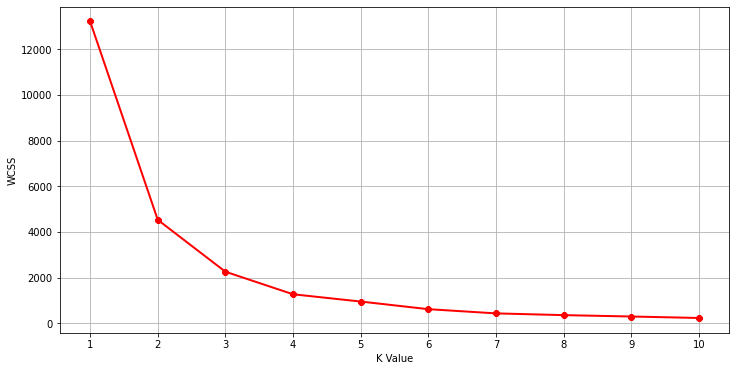

In [ ]:
from sklearn.cluster import KMeans
distortion_score = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_sales_complete)
    distortion_score.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),distortion_score , linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

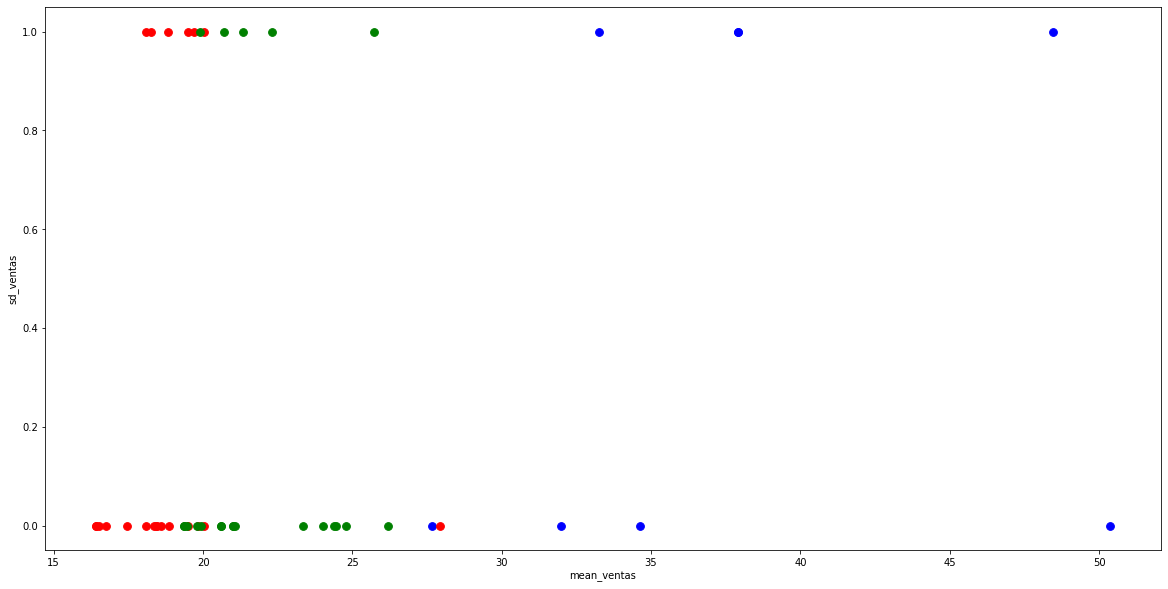

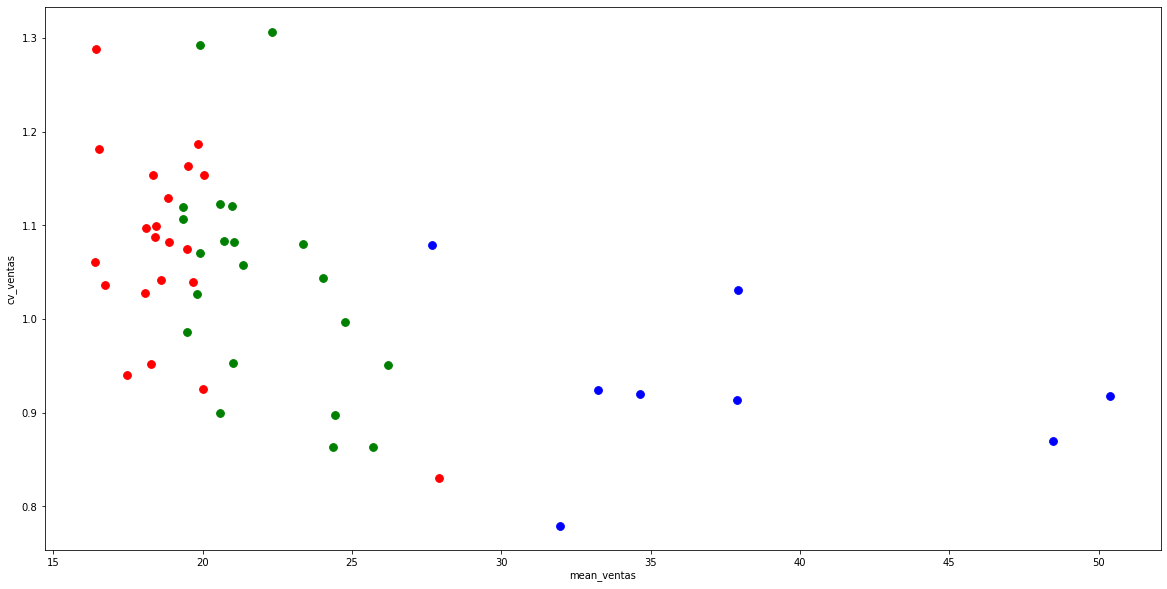

In [ ]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(df_sales_complete)
df_sales_complete["label"] = clusters

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.scatter(df_sales_complete.mean_ventas[df_sales_complete.label == 0], df_sales_complete["stationary"][df_sales_complete.label == 0], c='blue', s=60)
ax.scatter(df_sales_complete.mean_ventas[df_sales_complete.label == 1], df_sales_complete["stationary"][df_sales_complete.label == 1], c='red', s=60)
ax.scatter(df_sales_complete.mean_ventas[df_sales_complete.label == 2], df_sales_complete["stationary"][df_sales_complete.label == 2], c='green', s=60)
ax.scatter(df_sales_complete.mean_ventas[df_sales_complete.label == 3], df_sales_complete["stationary"][df_sales_complete.label == 3], c='pink', s=60)
plt.xlabel("mean_ventas")
plt.ylabel("sd_ventas")
plt.show()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.scatter(df_sales_complete.mean_ventas[df_sales_complete.label == 0], df_sales_complete.cv_ventas[df_sales_complete.label == 0], c='blue', s=60)
ax.scatter(df_sales_complete.mean_ventas[df_sales_complete.label == 1], df_sales_complete.cv_ventas[df_sales_complete.label == 1], c='red', s=60)
ax.scatter(df_sales_complete.mean_ventas[df_sales_complete.label == 2], df_sales_complete.cv_ventas[df_sales_complete.label == 2], c='green', s=60)
ax.scatter(df_sales_complete.mean_ventas[df_sales_complete.label == 3], df_sales_complete.cv_ventas[df_sales_complete.label == 3], c='pink', s=60)
plt.xlabel("mean_ventas")
plt.ylabel("cv_ventas")
plt.show()

In [ ]:
df_sales_complete.groupby("label").describe()

mean_ventas                                                        \
            count       mean       std        min        25%        50%   
label                                                                     
0             8.0  37.775685  7.920619  27.681018  32.930773  36.270059   
1            21.0  18.856770  2.380908  16.405088  18.084149  18.449119   
2            21.0  21.869350  2.227450  19.345401  19.924658  21.013699   

                            cv_ventas                                          \
             75%        max     count      mean       std       min       25%   
label                                                                           
0      40.554550  50.375734       8.0  0.929155  0.091926  0.779158  0.902904   
1      19.511742  27.922701      21.0  1.073641  0.103840  0.830010  1.036107   
2      24.013699  26.202544      21.0  1.043918  0.120143  0.863077  0.952594   

                                    stationary                                \
            50%       75%       max      count      mean       std  min  25%   
label                                                                          
0      0.918618  0.950384  1.078859        8.0  0.500000  0.534522  0.0  0.0   
1      1.081899  1.153225  1.287967       21.0  0.285714  0.462910  0.0  0.0   
2      1.057031  1.106516  1.306804       21.0  0.238095  0.436436  0.0  0.0   

                     diff_stationary                                          \
       50%  75%  max           count      mean       std  min  25%  50%  75%   
label                                                                          
0      0.5  1.0  1.0             8.0  0.500000  0.534522  0.0  0.0  0.5  1.0   
1      0.0  1.0  1.0            21.0  0.714286  0.462910  0.0  0.0  1.0  1.0   
2      0.0  0.0  1.0            21.0  0.761905  0.436436  0.0  1.0  1.0  1.0   

            
       max  
label       
0      1.0  
1      1.0  
2      1.0

## Archivo final

In [ ]:
df_promos_final = pd.merge(df_calendar, df_promos, how='left',left_on='sku', right_on='sku')
df_promos_final["promo"] = np.where((df_promos_final["fecha"]>=df_promos_final["fechaIni"]) & (df_promos_final["fecha"]<=df_promos_final["fechaFin"]), "1", "0")
df_promos_final = df_promos_final[df_promos_final.promo=='1']
df_promos_final = df_promos_final[['sku','fecha','promo']]

*Dataframe completo*

In [ ]:
df_tfm = df_sales_final.merge(df_stock, on=['sku','fecha'], how='left').merge(df_promos_final, on =['sku','fecha'], how='left').merge(df_sales_complete.reset_index()[["sku","label"]], on=['sku'], how='left')

In [ ]:
df_tfm['promo'] = np.where(df_tfm['promo'].isnull(), 0, df_tfm['promo'])

In [ ]:
df_tfm.head()

,sku,fecha,bolOpen,bolHoliday,udsVenta,udsVentaO,weekday,year_month,udsVentaT,udsStock,promo,label
0,12,2019-02-24,1,0,22.0,22.0,Sun,2019-02,22.0,NaN,1,2
1,12,2019-02-25,1,0,22.0,22.0,Mon,2019-02,22.0,NaN,1,2
2,12,2019-02-26,1,0,33.0,33.0,Tue,2019-02,33.0,NaN,1,2
3,12,2019-02-27,1,0,33.0,33.0,Wed,2019-02,33.0,NaN,1,2
4,12,2019-02-28,1,0,33.0,33.0,Thu,2019-02,33.0,NaN,0,2


*Guardar en csv para Tableau*

In [ ]:
df_tfm[['sku', 'fecha', 'bolOpen', 'bolHoliday', 'udsVenta', 'udsVentaO','udsStock', 'promo','udsVentaT', 'label']].to_csv (r'/content/drive/MyDrive/Files_TFM/export_data_tfm.csv', index = False, header=True)

*Verificar tipo de datos*

In [ ]:
df_tfm.drop(columns=["weekday","year_month"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51100 entries, 0 to 51099
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   sku         51100 non-null  object        
 1   fecha       51100 non-null  datetime64[ns]
 2   bolOpen     51100 non-null  int64         
 3   bolHoliday  51100 non-null  int64         
 4   udsVenta    51100 non-null  float64       
 5   udsVentaO   51100 non-null  float64       
 6   udsVentaT   51100 non-null  float64       
 7   udsStock    32900 non-null  float64       
 8   promo       51100 non-null  object        
 9   label       51100 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(2), object(2)
memory usage: 4.1+ MB


In [ ]:
df_num = df_tfm.drop(columns=["weekday","label","year_month"]).describe(include="number")
df_nonum = df_tfm.drop(columns=["weekday","label","year_month"]).describe(exclude="number")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



In [ ]:
print(tabulate(df_num, headers=df_num.columns, tablefmt='latex'))

\begin{tabular}{lrrrrrr}
\hline
       &      bolOpen &   bolHoliday &   udsVenta &   udsVentaO &   udsVentaT &   udsStock \\
\hline
 count & 51100        & 51100        & 51100      &  51100      &  51100      &  32900     \\
 mean  &     0.870587 &     0.158297 &    23.352  &     22.1279 &     23.1491 &    506.993 \\
 std   &     0.33566  &     0.365023 &    26.3281 &     26.4855 &     25.4576 &    467.177 \\
 min   &     0        &     0        &     0      &   -110      &      0      &   -440     \\
 25\%   &     1        &     0        &     0      &      0      &      0      &    264     \\
 50\%   &     1        &     0        &    17      &     11      &     17      &    385     \\
 75\%   &     1        &     0        &    33      &     33      &     33      &    550     \\
 max   &     1        &     1        &   352      &    352      &    187      &   3630     \\
\hline
\end{tabular}


In [ ]:
print(tabulate(df_nonum, headers=df_nonum.columns, tablefmt='latex'))

\begin{tabular}{lrlr}
\hline
        &   sku & fecha               &   promo \\
\hline
 count  & 51100 & 51100               &   51100 \\
 unique &    50 & 1022                &       2 \\
 top    &    14 & 2020-10-28 00:00:00 &       0 \\
 freq   &  1022 & 50                  &   28527 \\
 first  &   nan & 2019-01-02 00:00:00 &     nan \\
 last   &   nan & 2021-10-19 00:00:00 &     nan \\
\hline
\end{tabular}


In [ ]:
for i in range(1,51):
  plt.rcParams.update({'figure.figsize': (15,6)})
  fig, ax = plt.subplots() # Create the figure and axes object
  plt.plot(df_tfm[df_tfm["sku"] == str(i)].sort_values(by='fecha').set_index('fecha')[["udsVenta"]], 
           'red', label = "Datos Imputados", linewidth=0.5)
  plt.plot(df_tfm[df_tfm["sku"] == str(i)].sort_values(by='fecha').set_index('fecha')[["udsVentaO"]], 
           'r--', label = "Datos originales", linewidth=0.5)
  plt.plot(df_tfm[df_tfm["sku"] == str(i)].sort_values(by='fecha').set_index('fecha')[["udsVentaT"]], 
           'k', label = "Datos sin valores atípicos p99", linewidth=0.8)
  plt.legend()
  plt.xlabel('fecha')
  plt.ylabel('Ventas')
  plt.title("SKU " + str(i))
  plt.tight_layout()
  plt.savefig("/content/drive/MyDrive/Files_TFM/graficos/info_SKU_" + str(i) + ".png", dpi=300, bbox_inches='tight')
  plt.close()

In [ ]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
info = pd.read_csv("/content/drive/MyDrive/Files_TFM/export_data_tfm.csv",parse_dates=['fecha'], date_parser=dateparse)

In [ ]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51100 entries, 0 to 51099
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   sku         51100 non-null  int64         
 1   fecha       51100 non-null  datetime64[ns]
 2   bolOpen     51100 non-null  int64         
 3   bolHoliday  51100 non-null  int64         
 4   udsVenta    51100 non-null  float64       
 5   udsVentaO   51100 non-null  float64       
 6   udsStock    32900 non-null  float64       
 7   promo       51100 non-null  int64         
 8   label       51100 non-null  int64         
 9   udsVentaT   51100 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 3.9 MB


In [ ]:
info.columns

Index(['sku', 'fecha', 'bolOpen', 'bolHoliday', 'udsVenta', 'udsVentaO',
       'udsStock', 'promo', 'label', 'udsVentaT'],
      dtype='object')

In [ ]:
info[['sku', 'fecha', 'bolOpen', 'bolHoliday', 'udsVenta','udsStock', 'promo', 'label','udsVentaT',]].to_csv (r'/content/drive/MyDrive/export_data_tfm.csv', index = False, header=True)

In [ ]:
info.bolOpen = info.bolOpen.astype(str)
info.bolHoliday = info.bolHoliday.astype(str)
info.promo = info.promo.astype(str)
info.sku = info.sku.astype(str)
df_summ = info.drop(columns=["label"]).describe(include="all", datetime_is_numeric=True)

In [ ]:
print(tabulate(df_summ[['udsVentaO','udsVenta','udsVentaT','udsStock']], headers=['udsVentaO','udsVenta','udsVentaT','udsStock'], tablefmt='latex'))

\begin{tabular}{lrrrr}
\hline
        &   udsVentaO &   udsVenta &   udsVentaT &   udsStock \\
\hline
 count  &  51100      & 51100      &  51100      &  32900     \\
 unique &    nan      &   nan      &    nan      &    nan     \\
 top    &    nan      &   nan      &    nan      &    nan     \\
 freq   &    nan      &   nan      &    nan      &    nan     \\
 mean   &     22.1279 &    23.352  &     23.1491 &    506.993 \\
 min    &   -110      &     0      &      0      &   -440     \\
 25\%    &      0      &     0      &      0      &    264     \\
 50\%    &     11      &    17      &     17      &    385     \\
 75\%    &     33      &    33      &     33      &    550     \\
 max    &    352      &   352      &    187      &   3630     \\
 std    &     26.4855 &    26.3281 &     25.4576 &    467.177 \\
\hline
\end{tabular}


In [ ]:
print(tabulate(df_summ[["sku","fecha","bolOpen","bolHoliday","promo"]], headers=["sku","fecha","bolOpen","bolHoliday","promo"], tablefmt='latex'))

\begin{tabular}{lrlrrr}
\hline
        &   sku & fecha                         &   bolOpen &   bolHoliday &   promo \\
\hline
 count  & 51100 & 51100                         &     51100 &        51100 &   51100 \\
 unique &    50 & nan                           &         2 &            2 &       2 \\
 top    &    38 & nan                           &         1 &            0 &       0 \\
 freq   &  1022 & nan                           &     44487 &        43011 &   28527 \\
 mean   &   nan & 2020-05-26 12:00:00.000001280 &       nan &          nan &     nan \\
 min    &   nan & 2019-01-02 00:00:00           &       nan &          nan &     nan \\
 25\%    &   nan & 2019-09-14 00:00:00           &       nan &          nan &     nan \\
 50\%    &   nan & 2020-05-26 12:00:00           &       nan &          nan &     nan \\
 75\%    &   nan & 2021-02-06 00:00:00           &       nan &          nan &     nan \\
 max    &   nan & 2021-10-19 00:00:00           &       nan &          nan &   